In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from ml.features import add_composite_scores, college_features, noncollege_features
from ml.playstyles import compute_playstyle_clusters
from ml.weights import college_weights, noncollege_weights
from ml.team_needs import get_team_needs
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data for 2024 TESTING
year = 2024  # Change as needed

# Load player pool with stats
players_df = pd.read_csv(f"../data/processed/{year}/draftpool_stats_{year}.csv")
# Load draft order
draft_order = pd.read_csv(f"../data/processed/{year}/draft_{year}_team_stats.csv")["team"].tolist()
# load team stats
team_stats_df = pd.read_csv(f"../data/processed/{year}/draft_{year}_team_stats.csv")
# identify team needs
team_needs = get_team_needs(team_stats_df)
# Quick check
players_df.head()

,Name,Age,classification,Season,Pos,G,GS,MP,FG,FGA,...,FTAR,NBA 3P%,AST/USG,AST/TO,OWS/40,DWS/40,ORTG,DRTG,Unnamed: 19,WS/48
0,Reed Sheppard,19.99,College,NaN,G,33.0,5.0,28.9,4.3,8.0,...,0.247,0.388,1.34,2.24,0.126,0.059,129.4,103.1,NaN,NaN
1,Stephon Castle,19.63,College,NaN,G,34.0,30.0,27.0,4.0,8.5,...,0.379,0.336,0.84,1.94,0.109,0.074,119.7,99.3,NaN,NaN
2,Donovan Clingan,20.32,College,NaN,C,35.0,33.0,22.5,5.3,8.3,...,0.478,0.303,0.54,1.89,0.193,0.112,135.3,89.4,NaN,NaN
3,Rob Dillingham,19.46,College,NaN,G,32.0,1.0,23.3,5.4,11.3,...,0.271,0.385,0.98,1.94,0.139,0.038,118.0,109.8,NaN,NaN
4,Zach Edey,22.10,College,NaN,C,39.0,39.0,32.0,8.6,13.8,...,0.809,0.319,0.44,0.88,0.253,0.083,135.0,97.2,NaN,NaN


In [14]:
def score_player_for_team(player_row, team_needs, use_composite=True, composite_weight=0.5):
    """
    Compute how well a player fits a team's statistical needs.
    Optionally includes composite scores for Offense, Defense, and General.
    """
    score = 0.0
    
    # Score based on normalized team-need-aligned stats
    for stat, weight in team_needs.items():
        norm_stat = stat + "_norm"
        if norm_stat in player_row and not pd.isna(player_row[norm_stat]):
            score += weight * player_row[norm_stat]

    # Optionally blend in composite score
    if use_composite:
        comps = []
        for comp in ["OffenseScore", "DefenseScore", "GeneralScore"]:
            if comp in player_row and not pd.isna(player_row[comp]):
                comps.append(player_row[comp])
        if comps:
            composite_avg = np.mean(comps)
            score += composite_weight * composite_avg

    return score

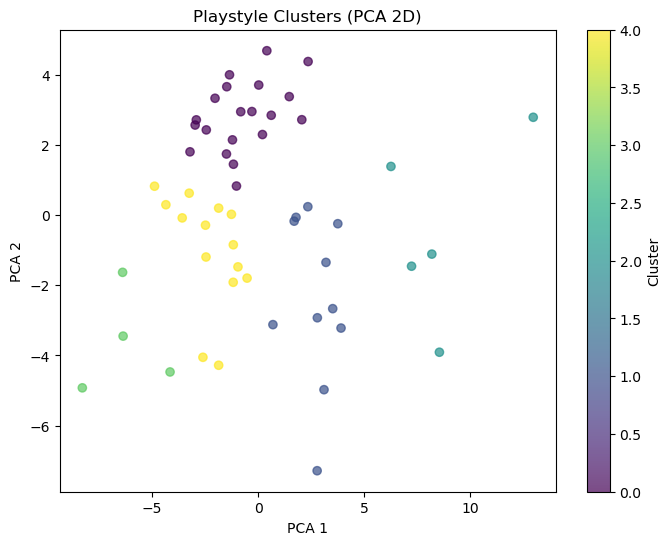

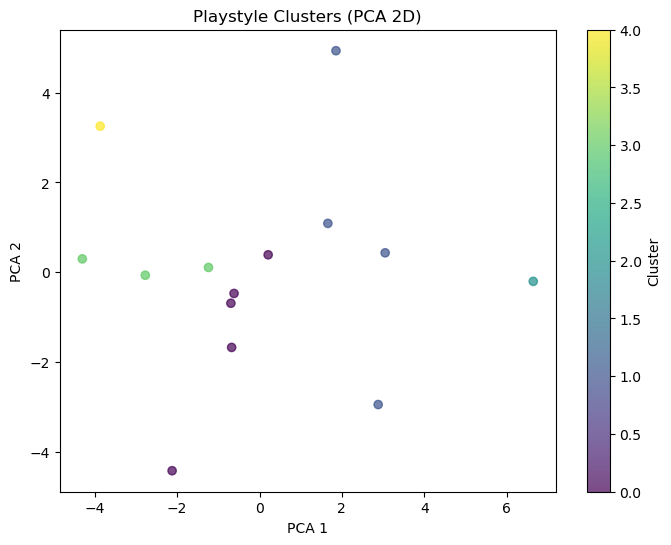

In [4]:
## 2024 TESTING
# Separate college and non-college
college_df = players_df[players_df["classification"] == "College"].copy()
noncollege_df = players_df[players_df["classification"] != "College"].copy()

# Apply clustering independently
college_df = compute_playstyle_clusters(college_df, feature_cols=college_features, plot=True)
noncollege_df = compute_playstyle_clusters(noncollege_df, feature_cols=noncollege_features, plot=True)

# Combine back
players_df = pd.concat([college_df, noncollege_df], ignore_index=True)

In [5]:
## 2024 TESTING
# just viewing players in each cluster to check
for cluster in range(5):
    print(f"Cluster {cluster}:")
    # Handle NaN values by filling them with a default value (e.g., -1) before conversion
    playstyle_int = players_df['Playstyle'].fillna(-1).astype(int)
    cluster_players = players_df[playstyle_int == cluster] 
    print(cluster_players[['Name']].head(10))  # Ensure column names match
    print("\n")

Cluster 0:
                    Name
0          Reed Sheppard
3         Rob Dillingham
6           Devin Carter
10         Dalton Knecht
13          Jaylon Tyson
17          Dillon Jones
18  Terrence Shannon Jr.
21     Baylor Scheierman
24           Tyler Kolek
26         Ajay Mitchell


Cluster 1:
               Name
8       Kel'el Ware
19        Ryan Dunn
23  Kyle Filipowski
28     Oso Ighodaro
29        Adem Bona
38     Quinten Post
40     Anton Watson
46  Isaiah Crawford
51          PJ Hall
52   Keshad Johnson


Cluster 2:
               Name
2   Donovan Clingan
4         Zach Edey
15  DaRon Holmes II
22   Jonathan Mogbo
37  Enrique Freeman
56      Ron Holland


Cluster 3:
                  Name
16      Kyshawn George
33        Cam Christie
41        Bronny James
48      Justin Edwards
59  Zaccharie Risacher
64       Pacome Dadiet
68       Melvin Ajinca


Cluster 4:
                  Name
1       Stephon Castle
5        Cody Williams
7   Carlton Carrington
9         Jared McCain
11 

In [6]:
## 2024 TESTING
# add composite scores
players_df = add_composite_scores(players_df, college_weights, noncollege_weights)
print(players_df.to_string())

                    Name    Age classification  Season Pos     G    GS    MP   FG   FGA    FG%   3P  3PA    3P%   2P   2PA    2P%   eFG%   FT   FTA    FT%  ORB  DRB   TRB  AST  STL  BLK  TOV   PF   PTS    PER    TS%   3PAr    FTr  PProd  ORB%  DRB%  TRB%  AST%  STL%  BLK%  TOV%   USG%  OWS  DWS    WS  WS/40  OBPM  DBPM   BPM   EFG%   3PAR   FTAR  NBA 3P%  AST/USG  AST/TO  OWS/40  DWS/40   ORTG   DRTG  Unnamed: 19  WS/48  Playstyle  OffenseScore  DefenseScore  GeneralScore
0          Reed Sheppard  19.99        College     NaN   G  33.0   5.0  28.9  4.3   8.0  0.536  2.3  4.4  0.521  2.0   3.6  0.555  0.679  1.6   2.0  0.831  0.4  3.8   4.1  4.5  2.5  0.7  2.0  1.9  12.5  23.60  0.699  0.548  0.247  421.0   1.5  13.3   7.7  24.1   4.6   2.5  18.3  18.00  3.0  1.4   4.5  0.188   6.4   5.0  11.4  0.679  0.548  0.247    0.388     1.34    2.24   0.126   0.059  129.4  103.1          NaN    NaN        0.0     40.022824     40.022824     40.022824
1         Stephon Castle  19.63        College

In [8]:
## 2024 TESTING

# 🧩 Normalize relevant player stats based on all team needs

# Step 1: Collect all features any team cares about
all_needed_stats = set()
for team, needs in team_needs.items():
    all_needed_stats.update(needs.keys())

# Step 2: Normalize those features across the player pool by classification
players_df_normalized = players_df.copy()

for stat in all_needed_stats:
    if stat in players_df_normalized.columns:
        for classification in players_df_normalized["classification"].unique():
            mask = players_df_normalized["classification"] == classification
            min_val = players_df_normalized.loc[mask, stat].min()
            max_val = players_df_normalized.loc[mask, stat].max()
            
            if max_val - min_val != 0:
                players_df_normalized.loc[mask, stat + "_norm"] = (
                    (players_df_normalized.loc[mask, stat] - min_val) / (max_val - min_val)
                )
            else:
                players_df_normalized.loc[mask, stat + "_norm"] = 0.5  # fallback if constant


In [9]:
## 2024 TESTING
selected_players = []

for team in draft_order:
    needs = team_needs.get(team, {})
    
    # Reset available players each time
    available_players = players_df_normalized[
        ~players_df_normalized["Name"].isin([p["Player"] for p in selected_players])
    ].copy()

    available_players["FitScore"] = available_players.apply(
        lambda row: score_player_for_team(row, needs, use_composite=True, composite_weight=0.2),
        axis=1
    )

    best_pick = available_players.sort_values("FitScore", ascending=False).iloc[0]

    selected_players.append({
        "Team": team,
        "Player": best_pick["Name"],
        "FitScore": best_pick["FitScore"]
    })


In [12]:
## 2024 TESTING
# Load simulated and actual data
sim_df = pd.DataFrame(selected_players)
actual_df = pd.read_csv("../data/raw/2024/draft_2024.csv")

print("Simulated Draft Picks:")
print(sim_df)

# Merge on player name to compare teams (main accuracy)
merged = sim_df.merge(actual_df, left_on="Player", right_on="player", how="left")
merged["Correct"] = merged["Team"] == merged["team"]

# 🔹 Metric 1: Exact team match
accuracy = merged["Correct"].mean()
print(f"✅ Draft Accuracy (Team Match): {accuracy:.2%}")

# 🔹 Metric 2: % of actual lottery picks selected in sim
# Assume first 14 picks in actual_df are lottery
actual_lottery_players = set(actual_df.sort_values("pick").head(14)["player"])
simulated_players = set(sim_df["Player"])

lottery_hits = actual_lottery_players.intersection(simulated_players)
lottery_accuracy = len(lottery_hits) / 14

print(f"🎯 Lottery Hit Rate (regardless of team): {lottery_accuracy:.2%}")

Simulated Draft Picks:
                      Team                Player   FitScore
0            Atlanta Hawks             Zach Edey  20.380951
1       Washington Wizards            KJ Simpson  14.680039
2          Houston Rockets          Dillon Jones  14.557427
3        San Antonio Spurs        Tristen Newton  13.911590
4          Detroit Pistons       Enrique Freeman  13.920857
5        Charlotte Hornets       DaRon Holmes II  13.848209
6   Portland Trail Blazers  Terrence Shannon Jr.  13.525872
7        San Antonio Spurs         Dalton Knecht  12.919969
8        Memphis Grizzlies          Devin Carter  12.993107
9                Utah Jazz     Baylor Scheierman  12.940927
10           Chicago Bulls        Trey Alexander  12.302515
11   Oklahoma City Thunder       Kyle Filipowski  12.196085
12        Sacramento Kings          Quinten Post  12.299892
13  Portland Trail Blazers        Jonathan Mogbo  12.128028
✅ Draft Accuracy (Team Match): 0.00%
🎯 Lottery Hit Rate (regardless of team):

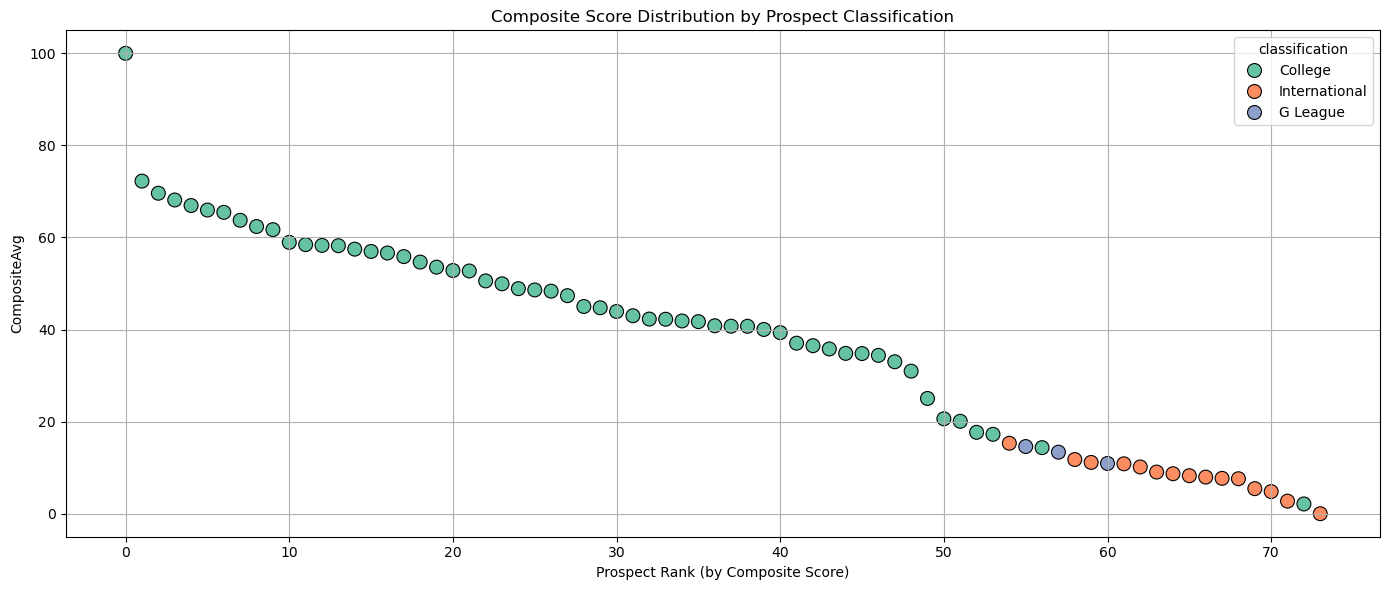

In [11]:
## 2024 TESTING
# Use mean of all composite scores
players_df_normalized["CompositeAvg"] = players_df_normalized[["OffenseScore", "DefenseScore", "GeneralScore"]].mean(axis=1)

# Sort and plot
sorted_players = players_df_normalized.sort_values("CompositeAvg", ascending=False).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=sorted_players,
    x=sorted_players.index,
    y="CompositeAvg",
    hue="classification",
    palette="Set2",
    s=100,
    edgecolor="black"
)
plt.title("Composite Score Distribution by Prospect Classification")
plt.xlabel("Prospect Rank (by Composite Score)")
plt.ylabel("CompositeAvg")
plt.grid(True)
plt.tight_layout()
plt.show()